In [674]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#import xgboost

% config InlineBackend.figure_format = 'png'
% matplotlib inline

from scipy.stats import shapiro
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Lasso
from math import ceil
from scipy.stats import skew

In [675]:
# Read the files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51dd5b7fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f51dd668630>]], dtype=object)

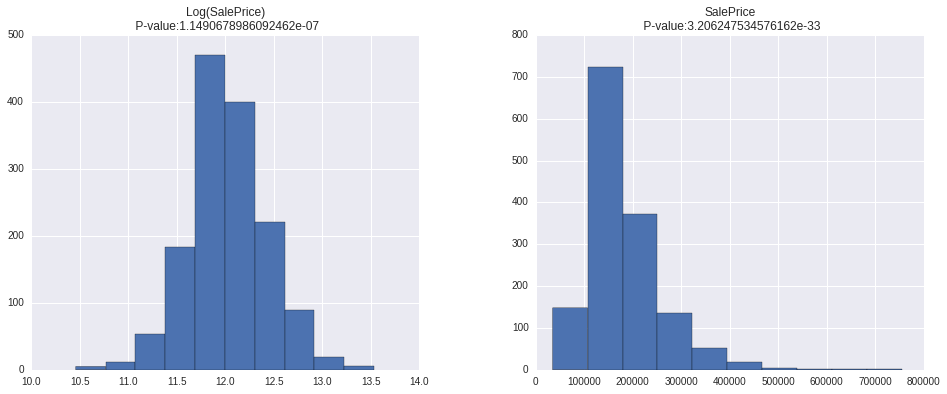

In [676]:
# Check distribution of prices and log(prices)
plt.rcParams['figure.figsize'] = (16.0, 6.0)
# Greater the p-value, greater is the normality in the distribution
pvalue_before = shapiro(train["SalePrice"])[1]
pvalue_after = shapiro(np.log(train["SalePrice"]))[1]
graph_data = pd.DataFrame(
        {
            ("SalePrice\n P-value:" + str(pvalue_before)) : train["SalePrice"],
            ("Log(SalePrice)\n P-value:" + str(pvalue_after)) : np.log(train["SalePrice"])
        }
    )
graph_data.hist()

In [677]:
# log transform SalePrice as it is approximately normal. If this distribution for SalePrice holds in the test set,
# log transforming the variable before training models will improve performance vastly.
# However, we cannot be completely certain that this distribution will hold in the test set.
train["SalePrice"] = np.log(train["SalePrice"])

In [678]:
# For feature engineering, combine train and test data
data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                  test.loc[:, 'MSSubClass':'SaleCondition']), ignore_index=True)

In [679]:
# MSSubClass, although numerical values, but actually represent categories
data = data.replace(
    {
        'MSSubClass': {
            20: 'MSSubClass_20',
            30: 'MSSubClass_30',
            40: 'MSSubClass_40',
            45: 'MSSubClass_45',
            50: 'MSSubClass_50',
            60: 'MSSubClass_60',
            70: 'MSSubClass_70',
            75: 'MSSubClass_75',
            80: 'MSSubClass_80',
            85: 'MSSubClass_85',
            90: 'MSSubClass_90',
            120: 'MSSubClass_120',
            150: 'MSSubClass_150',
            160: 'MSSubClass_160',
            180: 'MSSubClass_180',
            190: 'MSSubClass_190'
        }
    }
)

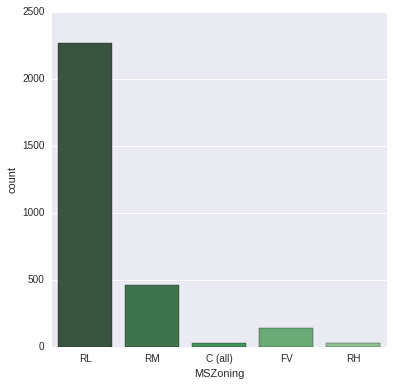

In [680]:
# MSZoning, Treat missing values to mode (treatment based on countplot)
plt.rcParams['figure.figsize'] = (6.0, 6.0)
sns.countplot(x='MSZoning', data=data, palette="Greens_d")
data.loc[data.MSZoning.isnull(), 'MSZoning'] = data.loc[:, 'MSZoning'].mode()[0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51ddc009e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f51ddb9ec50>]], dtype=object)

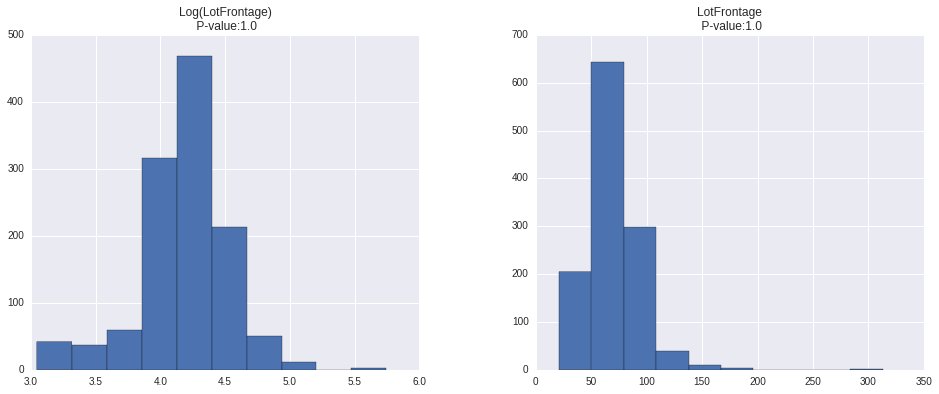

In [681]:
# Check distribution of prices and log(LotFrontage)
plt.rcParams['figure.figsize'] = (16.0, 6.0)
# Greater the p-value, greater is the normality in the distribution
pvalue_before = shapiro(train["LotFrontage"])[1]
pvalue_after = shapiro(np.log(train["LotFrontage"]))[1]
graph_data = pd.DataFrame(
        {
            ("LotFrontage\n P-value:" + str(pvalue_before)) : train["LotFrontage"],
            ("Log(LotFrontage)\n P-value:" + str(pvalue_after)) : np.log(train["LotFrontage"])
        }
    )
graph_data.hist()
# No improvement as detected by p-value. Let it be.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51ddbf2828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f51dd0ea9b0>]], dtype=object)

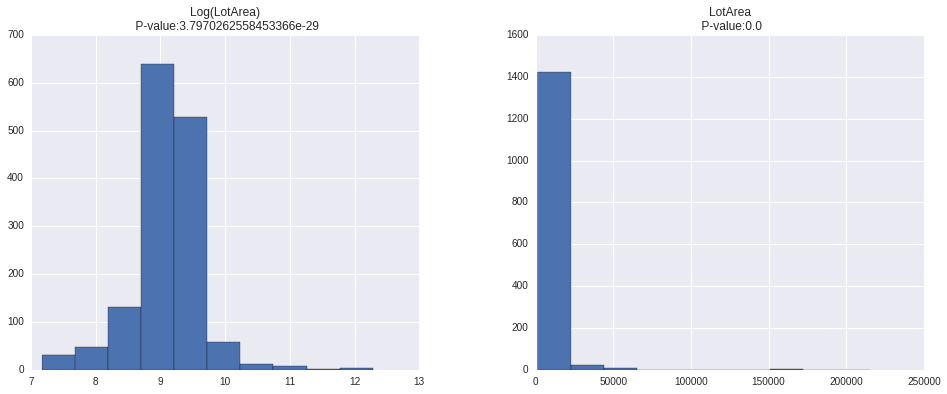

In [682]:
# Check distribution of prices and log(LotArea)
plt.rcParams['figure.figsize'] = (16.0, 6.0)
# Greater the p-value, greater is the normality in the distribution
pvalue_before = shapiro(train["LotArea"])[1]
pvalue_after = shapiro(np.log(train["LotArea"]))[1]
graph_data = pd.DataFrame(
        {
            ("LotArea\n P-value:" + str(pvalue_before)) : train["LotArea"],
            ("Log(LotArea)\n P-value:" + str(pvalue_after)) : np.log(train["LotArea"])
        }
    )
graph_data.hist()
# No improvement as detected by p-value. Let it be.

In [683]:
# We still have to do something about missing values of LotFrontage and LotArea
# For now filling them with zeros
data.loc[data.LotFrontage.isnull(), "LotFrontage"] = 0
data.loc[data.LotArea.isnull(), "LotArea"] = 0

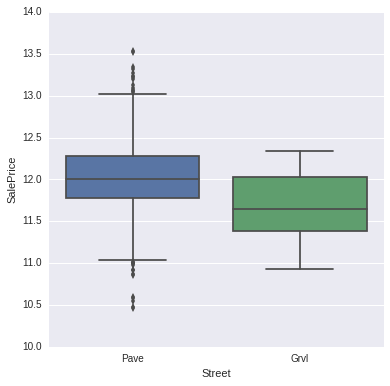

In [684]:
# Street, no missing values
plt.rcParams['figure.figsize'] = (6.0, 6.0)
sns.boxplot(x='Street', y='SalePrice', data=train)
data = data.replace(
    {
        'Street': {'Pave': 1, 'Grvl': 0 }
    }
)

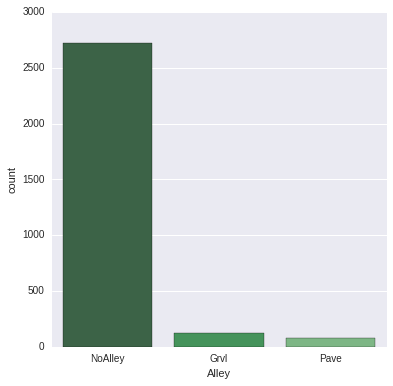

In [685]:
# Alley, can't use mode as shown below. Lot of missing values. So introduce NoAlley
data.loc[data.Alley.isnull(), 'Alley'] = 'NoAlley'
sns.countplot(x='Alley', data=data, palette="Greens_d")

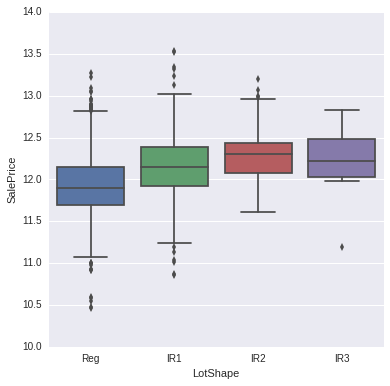

In [686]:
# LotShape, No missing values. Instead of ordering, prefer one hot encoding for this.
sns.boxplot(x='LotShape', y='SalePrice', data=train)

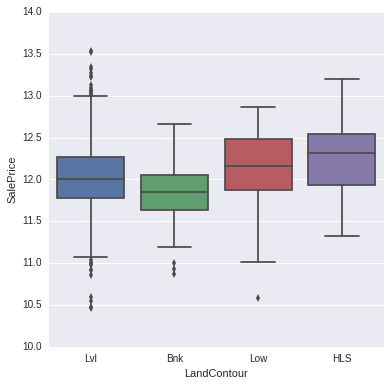

In [687]:
# LandContour, No missing values, Instead of ordering, prefer one hot encoding for this.
sns.boxplot(x='LandContour', y='SalePrice', data=train)

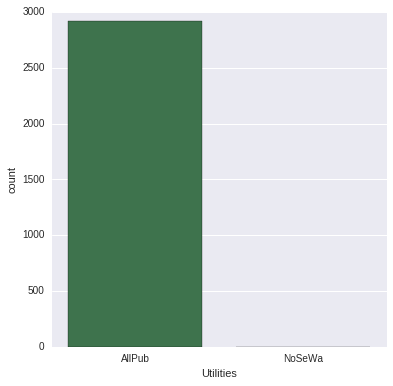

In [688]:
# Utilities. only 2 missing values. And mostly AllPub. Mode treatment. Ordering possible.
sns.countplot(x='Utilities', data=data, palette="Greens_d")
data.loc[data.Utilities.isnull(), 'Utilities'] = data.loc[:, 'Utilities'].mode()[0]
data = data.replace(
    {
        'Utilities': {
            'AllPub': 1,
            'NoSeWa': 0,
        }
    }
)

In [689]:
# LotConfig, LandSlope, no missing values.
data.loc[data.LotConfig.isnull(), 'LotConfig']

Series([], Name: LotConfig, dtype: object)

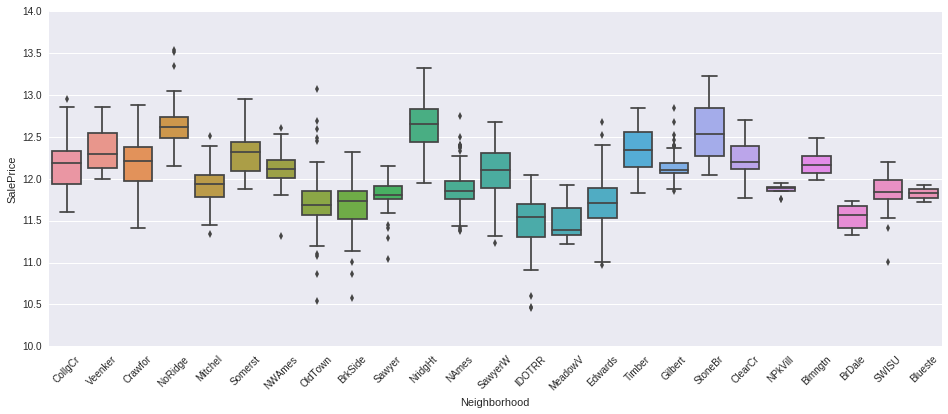

In [690]:
# Neighborhood, no missing values.
plt.figure(figsize = (16, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train)
xt = plt.xticks(rotation=45)

In [691]:
# Reward good neighborhoods, since it looks like an important feature.
NeighborhoodReward = pd.DataFrame(np.zeros((data.shape[0], 1)), columns=['NeighborhoodReward'])
NeighborhoodReward.loc[data.Neighborhood == 'StoneBr', 'NeighborhoodReward'] = 1
NeighborhoodReward.loc[data.Neighborhood == 'NridgHt', 'NeighborhoodReward'] = 1
NeighborhoodReward.loc[data.Neighborhood == 'NoRidge', 'NeighborhoodReward'] = 1
data['NeighborhoodReward'] = NeighborhoodReward

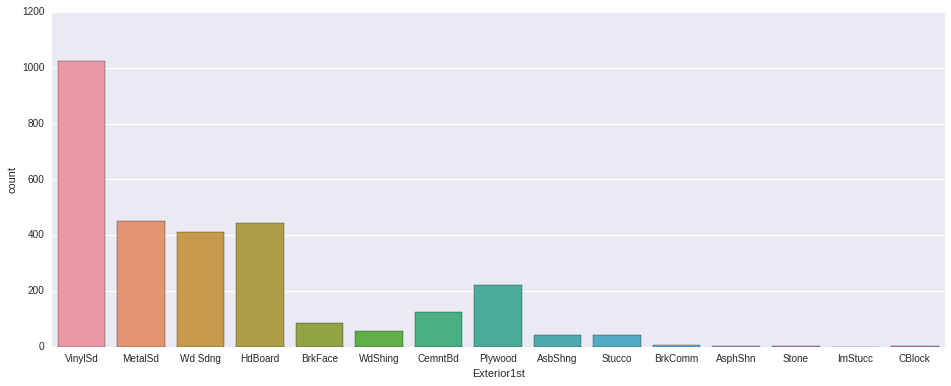

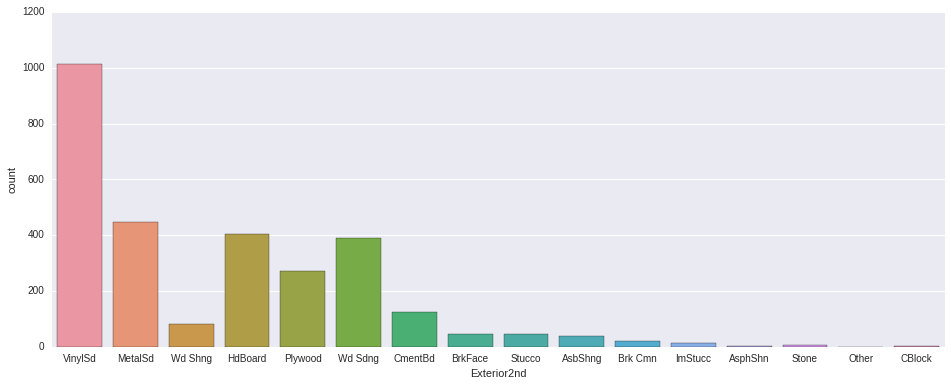

In [692]:
# Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond,
# YearBuilt, YearRemodAdd, RoofStyle, RoofMatl --- no missing values.
# For Exterior1st, Exterior2nd, Treat missing values to mode (treatment based on countplot)
plt.figure(figsize = (16, 6))
sns.countplot(x='Exterior1st', data=data)
plt.figure(figsize = (16, 6))
sns.countplot(x='Exterior2nd', data=data)
data.loc[data.Exterior1st.isnull(), 'Exterior1st'] = data.loc[:, 'Exterior1st'].mode()[0]
data.loc[data.Exterior2nd.isnull(), 'Exterior2nd'] = data.loc[:, 'Exterior2nd'].mode()[0]

In [693]:
# Check if house has been remodelled after buying.
IsRemodelled = pd.DataFrame(np.zeros((data.shape[0],1)), columns=['IsRemodelled'])
IsRemodelled[data.YrSold <= data.YearRemodAdd] = 1

# For memory efficiency
IsRemodelled = IsRemodelled.to_sparse()
data['IsRemodelled'] = IsRemodelled

In [694]:
# Check if house has been sold in the same year as it was built.
IsSameSoldBuilt = pd.DataFrame(np.zeros((data.shape[0],1)), columns=['IsSameSoldBuilt'])
IsSameSoldBuilt[data.YearBuilt >= data.YrSold] = 1

# For memory efficiency
IsSameSoldBuilt = IsSameSoldBuilt.to_sparse()
data['IsSameSoldBuilt'] = IsSameSoldBuilt

In [695]:
# To model inflation or change in trend of prices over time.
data.YrSold = data.loc[:, "YrSold"].max() - data.YrSold

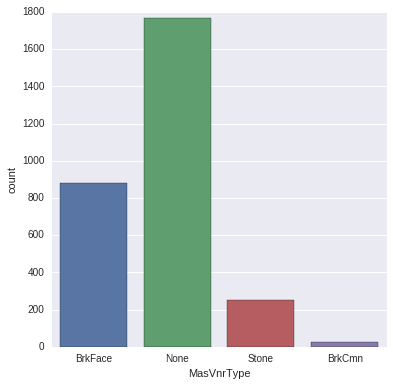

In [696]:
# MasVnrType, can't use mode as shown below. Lot of missing values. So introduce None
data.loc[data.MasVnrType.isnull(), 'MasVnrType'] = 'None'
plt.figure(figsize = (6, 6))
sns.countplot(x='MasVnrType', data=data)
# For null type, area is null too. making it zero makes sense
data.loc[data.MasVnrType == 'None', 'MasVnrArea'] = 0

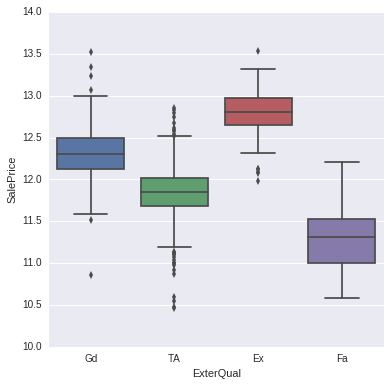

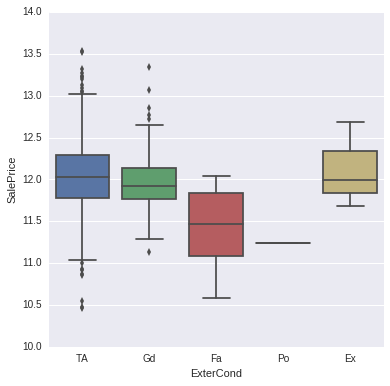

In [697]:
# ExterQual, ExterCond no missing values. Can order based on boxplots as well as meaning of domain.
plt.figure(figsize = (6, 6))
sns.boxplot(x='ExterQual', y='SalePrice', data=train)
plt.figure(figsize = (6, 6))
sns.boxplot(x='ExterCond', y='SalePrice', data=train)
data = data.replace(
    {
        'ExterQual': {'Ex': 5,
                      'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                      'Po': 1
                     },
        'ExterCond': {'Ex': 5,
                      'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                      'Po': 1
                     }
    }
)

In [698]:
# Foundation, no missing values
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2. Treat missing values to new values.
# Ordering is possible.
# for categorical and zero for numerical.
data.loc[data.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
data.loc[data.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
data.loc[data.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
data.loc[data.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
data.loc[data.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'
data.loc[data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
data.loc[data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
data.loc[data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
data.loc[data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0
data = data.replace(
    {
        'BsmtExposure': {
            'Gd': 3,
            'Av': 2,
            'Mn': 1,
            'No': 0,
            'NoBsmt': 0
        },
        'BsmtCond': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NoBsmt': 0
        },
    }
)

In [699]:
# Continuing in similar manner as above.
# Heating, HeatingQC, CentralAir, no missing values. Ordering possible for HeatingQC, CentralAir.
data = data.replace(
    {
        'HeatingQC': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1            
        },
        'CentralAir': {
            'Y': 1,
            'N': 0
        }
    }
)

# Electrical, Treat missing values to mode.
data.loc[data.Electrical.isnull(), 'Electrical'] = data.loc[:, 'Electrical'].mode()[0]

# 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, no missing values, numerical.

# BsmtFullBath, BsmtHalfBath. Treat missing values to 0
data.loc[data.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
data.loc[data.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0

# FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, no missing values

# KitchenQual, Treat missing value to mode. Ordering is possible.
data.loc[data.KitchenQual.isnull(), 'KitchenQual'] = data.loc[:, 'KitchenQual'].mode()[0]
data = data.replace(
    {
        'KitchenQual': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1
        }
    }
)

# Functional, Treat missing value to new value. Ordering is possible.
data.loc[data.Functional.isnull(), 'Functional'] = 'Typ'
data = data.replace(
    {
        'Functional': {
            'Typ': 0,
            'Min1': 1,
            'Min2': 1,
            'Mod': 2,
            'Maj1': 3,
            'Maj2': 4,
            'Sev': 5,
            'Sal': 6
            }
    }
)

# Fireplaces, no missing values

# FireplaceQu, Treat missing value to new value, and ordering is possible
data.loc[data.FireplaceQu.isnull(), 'FireplaceQu'] = 'NoFireplace'
data = data.replace(
    {
        'FireplaceQu': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NoFireplace': 0
        }
    }
)

# GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond.
# Treat missing value to new value, and
# ordering is possible for GarageQual, GarageCond
data.loc[data.GarageType.isnull(), 'GarageType'] = 'NoGarage'
data.loc[data.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'
data.loc[data.GarageQual.isnull(), 'GarageQual'] = 'NoGarage'
data.loc[data.GarageCond.isnull(), 'GarageCond'] = 'NoGarage'
data.loc[data.GarageYrBlt.isnull(), 'GarageYrBlt'] = 'NoGarage'
data = data.replace(
    {
        'GarageQual': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NoGarage': 0
        },
        'GarageCond': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NoGarage': 0
        },
    }
)

In [700]:
# Continuing in similar manner as above.

# PavedDrive, no missing value, ordering is possible, based on boxplot
data = data.replace(
    {
        'PavedDrive': {
            'Y': 1,
            'P': 0.5,
            'N': 0
        }
    }
)

# PoolQC, Fence, Treat missing values to new value. ordering is possible, based on boxplot and meaning of domain.
data.loc[data['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'
data.loc[data['Fence'].isnull(), 'Fence'] = 'NoFence'
data = data.replace(
    {
        'PoolQC': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
        },
        'Fence': {
            'GdPrv': 2,
            'MnPrv': 1,
            'GdWo': 2,
            'MnWw': 1,
            'NoFence': 0
        }
    }
)

# MiscFeature, Treat missing values to new value. Will prefer one-hot encoding for this.
data.loc[data['MiscFeature'].isnull(), 'MiscFeature'] = 'None'

# SaleType, Fix missing value to mode.
data.loc[data['SaleType'].isnull(), 'SaleType'] = data.loc[:, 'SaleType'].mode()[0]

In [701]:
# GarageCars, GarageArea. Numerical. Only one missing value whose GarageType is Detchd.
# Treat missing value to median (for cars as we want whole number) and
# mean (for GarageArea as it is double), of its garage type.
data.loc[data['GarageCars'].isnull(), 'GarageCars'] = data.loc[data.GarageType == 'Detchd', 'GarageCars'].median()
data.loc[data['GarageArea'].isnull(), 'GarageArea'] = data.loc[data.GarageType == 'Detchd', 'GarageArea'].mean()

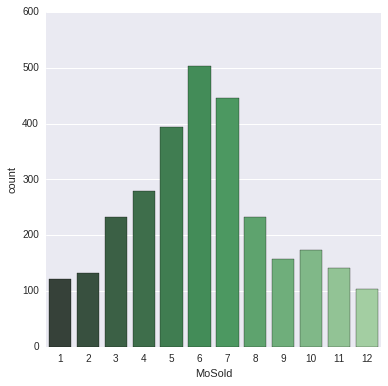

In [702]:
# Months with the maximum number of deals may be significant
sns.countplot(x='MoSold', data=data, palette="Greens_d")
SellingSeason = data.MoSold.replace(
    {
        1: 0,
        2: 0,
        3: 0,
        4: 1,
        5: 1,
        6: 1,
        7: 1,
        8: 0,
        9: 0,
        10: 0,
        11: 0,
        12: 0
    }
)
data['SellingSeason'] = SellingSeason

# Number of month should not be taken numerical but categorical
data = data.replace(
    {
        'MoSold': {
            1: 'Jan',
            2: 'Feb',
            3: 'Mar',
            4: 'Apr',
            5: 'May', 
            6: 'Jun',
            7: 'Jul',
            8: 'Aug',
            9: 'Sep',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec'
        }
    }
)

In [703]:
# Reward good qualities and penalise bad qualities, for quality based fatures.

# OverallQual
IsOverallQualPoor = data.OverallQual.copy()
IsOverallQualPoor[IsOverallQualPoor <= 5] = 1
IsOverallQualPoor[IsOverallQualPoor > 5] = 0
data['IsOverallQualPoor'] = IsOverallQualPoor

IsOverallQualGood = data.OverallQual.copy()
IsOverallQualGood[IsOverallQualGood <= 5] = 0
IsOverallQualGood[IsOverallQualGood > 5] = 1
data['IsOverallQualGood'] = IsOverallQualGood

# OverallCond
IsOverallCondPoor = data.OverallCond.copy()
IsOverallCondPoor[IsOverallCondPoor <= 5] = 1
IsOverallCondPoor[IsOverallCondPoor > 5] = 0
data['IsOverallCondPoor'] = IsOverallCondPoor

IsOverallCondGood = data.OverallCond.copy()
IsOverallCondGood[IsOverallCondGood <= 5] = 0
IsOverallCondGood[IsOverallCondGood > 5] = 1
data['IsOverallCondGood'] = IsOverallCondGood

# ExterQual
IsExterQualPoor = data.ExterQual.copy()
IsExterQualPoor[IsExterQualPoor <= 2] = 1
IsExterQualPoor[IsExterQualPoor > 2] = 0
data['IsExterQualPoor'] = IsExterQualPoor

IsExterQualGood = data.ExterQual.copy()
IsExterQualGood[IsExterQualGood <= 2] = 0
IsExterQualGood[IsExterQualGood > 2] = 1
data['IsExterQualGood'] = IsExterQualGood

# ExterCond
IsExterCondPoor = data.ExterCond.copy()
IsExterCondPoor[IsExterCondPoor <= 2] = 1
IsExterCondPoor[IsExterCondPoor > 2] = 0
data['IsExterCondPoor'] = IsExterCondPoor

IsExterCondGood = data.ExterCond.copy()
IsExterCondGood[IsExterCondGood <= 2] = 0
IsExterCondGood[IsExterCondGood > 2] = 1
data['IsExterCondGood'] = IsExterCondGood

# BsmtCond
IsBsmtCondPoor = data.BsmtCond.copy()
IsBsmtCondPoor[IsBsmtCondPoor <= 3] = 1
IsBsmtCondPoor[IsBsmtCondPoor > 3] = 0
data['IsBsmtCondPoor'] = IsBsmtCondPoor

IsBsmtCondGood = data.BsmtCond.copy()
IsBsmtCondGood[IsBsmtCondGood <= 3] = 0
IsBsmtCondGood[IsBsmtCondGood > 3] = 1
data['IsBsmtCondGood'] = IsBsmtCondGood

# GarageQual
IsGarageQualPoor = data.GarageQual.copy()
IsGarageQualPoor[IsGarageQualPoor <= 3] = 1
IsGarageQualPoor[IsGarageQualPoor > 3] = 0
data['IsGarageQualPoor'] = IsGarageQualPoor

IsGarageQualGood = data.GarageQual.copy()
IsGarageQualGood[IsGarageQualGood <= 3] = 0
IsGarageQualGood[IsGarageQualGood > 3] = 1
data['IsGarageQualGood'] = IsGarageQualGood

# GarageCond
IsGarageCondPoor = data.GarageCond.copy()
IsGarageCondPoor[IsGarageCondPoor <= 3] = 1
IsGarageCondPoor[IsGarageCondPoor > 3] = 0
data['IsGarageCondPoor'] = IsGarageCondPoor

IsGarageCondGood = data.GarageCond.copy()
IsGarageCondGood[IsGarageCondGood <= 3] = 0
IsGarageCondGood[IsGarageCondGood > 3] = 1
data['IsGarageCondGood'] = IsGarageCondGood

# KitchenQual
IsKitchenQualPoor = data.KitchenQual.copy()
IsKitchenQualPoor[IsKitchenQualPoor <= 2] = 1
IsKitchenQualPoor[IsKitchenQualPoor > 2] = 0
data['IsKitchenQualPoor'] = IsKitchenQualPoor

IsKitchenQualGood = data.KitchenQual.copy()
IsKitchenQualGood[IsKitchenQualGood <= 2] = 0
IsKitchenQualGood[IsKitchenQualGood > 2] = 1
data['IsKitchenQualGood'] = IsKitchenQualGood

# HeatingQC
IsHeatingQCPoor = data.HeatingQC.copy()
IsHeatingQCPoor[IsHeatingQCPoor <= 2] = 1
IsHeatingQCPoor[IsHeatingQCPoor > 2] = 0
data['IsHeatingQCPoor'] = IsHeatingQCPoor

# Reward if any MasVnr is present.
IsMasVnrTypePresent = data.MasVnrType.copy()
IsMasVnrTypePresent[IsMasVnrTypePresent == "None"] = 0
IsMasVnrTypePresent[IsMasVnrTypePresent != 0] = 1
data['IsMasVnrTypePresent'] = IsMasVnrTypePresent

# Penalise bad SaleCondition
IsSaleConditionPoor = data.SaleCondition.copy()
IsSaleConditionPoor[IsSaleConditionPoor == "Normal"] = 0
IsSaleConditionPoor[IsSaleConditionPoor == "Partial"] = 0
IsSaleConditionPoor[IsSaleConditionPoor == "Abnorml"] = 1
IsSaleConditionPoor[IsSaleConditionPoor == "Alloca"] = 1
IsSaleConditionPoor[IsSaleConditionPoor == "AdjLand"] = 1
IsSaleConditionPoor[IsSaleConditionPoor == "Family"] = 1
data['IsSaleConditionPoor'] = IsSaleConditionPoor

In [704]:
# Translate years to year groups, making them categorical
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871 + i*20, 1891 + i*20)) for i in range(0, 7))
data.GarageYrBlt = data.GarageYrBlt.map(year_map)
data.YearBuilt = data.YearBuilt.map(year_map)
data.YearRemodAdd = data.YearRemodAdd.map(year_map)

In [705]:
# For features Exterior1st, Exterior2nd, RoofMatl, Condition1, Condition2, BldgType
# Predict Classes of SalePrice (SalePrice Groups) using SVM.
# C is a penalty factor for error
columns_for_pc = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']
svm = SVC(C=100)

# Three price categories (based on histogram of SalePrice)
pc = pd.Series(np.zeros(train.shape[0]))
pc[np.exp(train.SalePrice) < 150000] = 'pc1'
pc[np.exp(train.SalePrice) >= 150000] = 'pc2'
pc[np.exp(train.SalePrice) >= 220000] = 'pc3'

# One hot encoding
pc_data = pd.get_dummies(train.loc[:, columns_for_pc], sparse=True)

# Train
svm.fit(pc_data, pc)

# Predict
SalePriceGrp = pd.DataFrame(np.zeros((data.shape[0],1)), columns=['SalePriceGrp'])
pc_data = pd.get_dummies(data.loc[:, columns_for_pc], sparse=True)
pc_pred = svm.predict(pc_data)
SalePriceGrp[pc_pred=='pc2'] = 1
SalePriceGrp[pc_pred=='pc3'] = 2
SalePriceGrp = SalePriceGrp.to_sparse()
data["SalePriceGrp"] = SalePriceGrp

In [706]:
# Skipping normalisation/scaling of numerical data for now

# log transform skewed numeric features
numeric_features = data.dtypes[data.dtypes != "object"].index

skewed_features = data[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.2]


skewed_features = skewed_features.index

data[skewed_features] = np.log1p(data[skewed_features])

In [707]:
# One hot encoding for remaining categorical features
data_processed = pd.get_dummies(data)

In [708]:
# Skipping normalisation/scaling of numerical data for now

# log transform skewed numeric features
numeric_features = data.dtypes[data.dtypes != "object"].index

skewed_features = data[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.2]


skewed_features = skewed_features.index

data[skewed_features] = np.log1p(data[skewed_features])

In [709]:
# Drop any features which are too overfitted to training data. 
# According to validation, doesn't improve anything
data_processed = data_processed.drop('RoofMatl_ClyTile', axis=1) # only one is not zero
data_processed = data_processed.drop('Condition2_PosN', axis=1) # only two is not zero
data_processed = data_processed.drop('MSZoning_C (all)', axis=1)
data_processed = data_processed.drop('MSSubClass_MSSubClass_160', axis=1)

In [710]:
"""# This is doing no good at all!
# Generation of features from sum and product of existing features.
# If they are redundant, lasso will reject them automatically
areas = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'BsmtUnfSF']
qualities = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual',
             'GarageCond', 'KitchenQual', 'HeatingQC', 'IsHeatingQCPoor', 'IsMasVnrTypePresent_1',
             'IsSaleConditionPoor_1', 'IsRemodelled', 'IsSameSoldBuilt']
for area in areas:
    for quality in qualities:
        data_processed[area + "_" + quality] = data_processed[area]*data_processed[quality]"""

'# This is doing no good at all!\n# Generation of features from sum and product of existing features.\n# If they are redundant, lasso will reject them automatically\nareas = [\'LotArea\', \'TotalBsmtSF\', \'GrLivArea\', \'GarageArea\', \'BsmtUnfSF\']\nqualities = [\'OverallQual\', \'OverallCond\', \'ExterQual\', \'ExterCond\', \'BsmtCond\', \'GarageQual\',\n             \'GarageCond\', \'KitchenQual\', \'HeatingQC\', \'IsHeatingQCPoor\', \'IsMasVnrTypePresent_1\',\n             \'IsSaleConditionPoor_1\', \'IsRemodelled\', \'IsSameSoldBuilt\']\nfor area in areas:\n    for quality in qualities:\n        data_processed[area + "_" + quality] = data_processed[area]*data_processed[quality]'

In [711]:
# Split back data to train and test
train_processed = data_processed[:train.shape[0]]
test_processed = data_processed[train.shape[0]:]

In [712]:
# Skipping any iterational improvement on SaleCondition_Partial and GrLivArea for now

In [713]:
# Skipping any outlier removal for now
train_processed = train_processed.drop([523, 1298])
train = train.drop([523, 1298])

In [714]:
# Skipping procedure to find best alpha for now

In [715]:
def learning_iterate():
    
    # Partition train into learning part and validation part in 70% : 30% ratio
    train_augment = train_processed.copy()
    train_augment["SalePrice"] = train["SalePrice"]
    # train_randomised = train_augment.iloc[np.random.permutation(train_augment.shape[0])]
    train_randomised = train_augment
    first_70cent = ceil(train_randomised.shape[0]*0.7)
    train_learning = train_randomised[:first_70cent]
    train_validation = train_randomised[first_70cent:]

    # Apply Lasso model
    lasso_model = Lasso(alpha=5e-4,
                        max_iter=50000).fit(
                                            train_learning.ix[:, train_learning.columns != "SalePrice"],
                                            train_learning["SalePrice"]
                                            )
    
    # Apply xgb model, gamma check later
    # xgb_model = xgb.XGBRegressor(
    #                             n_estimators=360,
    #                             max_depth=2,
    #                             learning_rate=0.1).fit(
    #                                                    train_learning.ix[:, train_learning.columns != "SalePrice"],
    #                                                    train_learning["SalePrice"]
    #                                                   )    
    
    predictions = lasso_model.predict(train_validation.ix[:, train_learning.columns != "SalePrice"])
    #predictions = xgb_model.predict(train_validation.ix[:, train_learning.columns != "SalePrice"])
    
    rmse = np.sqrt(mean_squared_error(train_validation["SalePrice"], predictions))
    
    return rmse

In [716]:
learning_iterate()

0.11485029449876144

In [717]:
# Apply Lasso model
lasso_model = Lasso(alpha=5e-4, max_iter=50000).fit(train_processed, train["SalePrice"])
predictions = np.exp(lasso_model.predict(test_processed))
solution = pd.DataFrame(
    {
        "Id" : test.Id,
        "SalePrice" : predictions
    }, 
    columns=['Id', 'SalePrice']
)
solution.to_csv("lasso_sol.csv", index = False)